In [1]:
import graphblas as gb
gb.init("suitesparse", blocking=False)

from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder
from graphblas.io import mmread
import numpy as np

**Наивный алгоритм**

In [2]:
def naive_A3(A):
    # Возводим матрицу А в куб
    tri = A @ A @ A
    # Извлекаем диагональные элементы
    diag = tri.diag()
    # Суммируем все элементы диагонали
    total_triangles = diag.reduce(gb.agg.sum).new()
    # Проверяем, есть ли значение, если нет, возвращаем 0
    return 0 if total_triangles.value is None else int(total_triangles.value // 6)

**Наивный алгоритм с маской**

In [3]:
def naive_mask_A2(A):
    # Возводим матрицу А в квадрат с применением маски А
    tri = (A @ A).dup(mask=A.dup(dtype=dtypes.BOOL))
    # Суммируем все элементы
    total_triangles = tri.reduce_scalar(monoid.plus).new()
    # Проверяем, есть ли значение, если нет, возвращаем 0
    return 0 if total_triangles.value is None else int(total_triangles.value // 6)

**Cohen's алгоритм**

In [4]:
def cohen(A):
    # Выбираем нижнюю треугольную часть матрицы
    L = gb.select.tril(A)
    # Выбираем верхнюю треугольную часть матрицы
    U = gb.select.triu(A)
    # Умножаем нижне-треугольную матрицу на верхне-треугольную
    B = L @ U
    # Применяем к результату маску А
    C = B.dup(mask=A.dup(dtype=dtypes.BOOL))
    # Складываем все элементы в получившейся матрице
    total_triangles = C.reduce_scalar(gb.monoid.plus).new()
    # Проверяем, есть ли значение, если нет, возвращаем 0
    return 0 if total_triangles.value is None else int(total_triangles.value // 2)

**Sandia алгоритм**

In [5]:
def sandia(A):
    # Выбираем нижнюю треугольную часть матрицы
    L = gb.select.tril(A)
    # Умножаем нижнюю треугольную матрицу на себя
    B = L @ L
    # Применяем крезультату маску L
    C = B.dup(mask=L.dup(dtype=dtypes.BOOL))
    # Суммируем все полученные элементы
    total_triangles = C.reduce_scalar(gb.monoid.plus).new()
    # Проверяем, есть ли значение, если нет, возвращаем 0
    return 0 if total_triangles.value is None else int(total_triangles)

**Функция подсчета количество треугольников для вершины**

In [6]:
def count_triangles_per_vertex(A):
    # Возводим матрицу А в куб
    tri = A @ A @ A
    # Извлекаем диагональные элементы
    diag = tri.diag()
    result = diag.apply(lambda x: x//2)
    return result

**Тестирование реализаций**

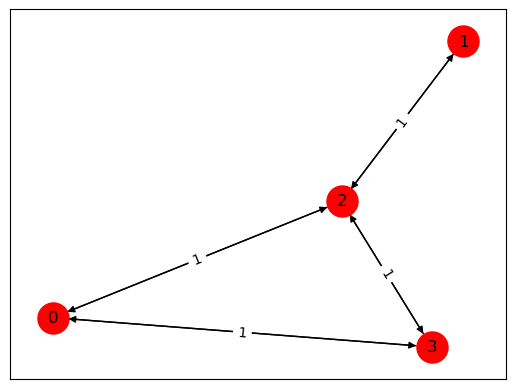

gb.VectorExpression               size  dtype
v_1.apply(unary.<lambda>[INT64])     4  INT64

"Result"   nvals  size  dtype
gb.Vector      3     4  INT64
-----------------------------
index  0 1  2  3
value  1    1  1

Do expr.new() or other << expr to calculate the expression.

In [7]:
#для начала задам простой граф с 4 вершинами и 1 треугольником, в котором участвуют вершины 0, 2 и 3.
M1=gb.Matrix.from_coo(
    [0,2,0,1,2,2,3,3],
    [2,0,3,2,1,3,0,2],
    [1,1,1,1,1,1,1,1],
    nrows=4,
    ncols=4
)
gb.viz.draw(M1)
#проверяю, что все функции возвращают корректный результат
assert naive_A3(M1) == 1
assert naive_mask_A2(M1) == 1
assert cohen(M1) == 1
assert sandia(M1) == 1
count_triangles_per_vertex(M1)

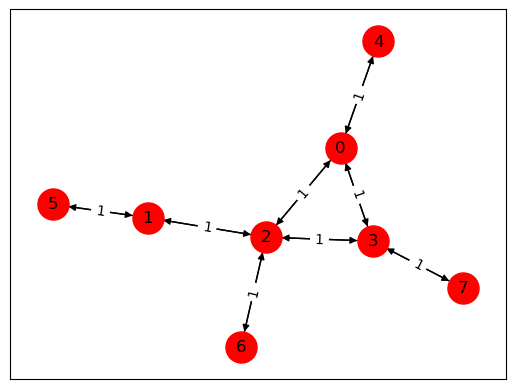

gb.VectorExpression               size  dtype
v_5.apply(unary.<lambda>[INT64])     8  INT64

"Result"   nvals  size  dtype
gb.Vector      3     8  INT64
-----------------------------
index  0 1  2  3 4 5 6 7
value  1    1  1        

Do expr.new() or other << expr to calculate the expression.

In [8]:
#увеличу количество вершин до 8, при это оставлю 1 треугольник, в котором участвуют вершины 0, 2 и 3.
M2=gb.Matrix.from_coo(
    [0,2,0,1,2,2,3,3,4,5,6,7,3,2,1,0],
    [2,0,3,2,1,3,0,2,0,1,2,3,7,6,5,4],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    nrows=8,
    ncols=8
)
gb.viz.draw(M2)
#проверяю, что все функции возвращают корректный результат
assert naive_A3(M2) == 1
assert naive_mask_A2(M2) == 1
assert cohen(M2) == 1
assert sandia(M2) == 1
count_triangles_per_vertex(M2)

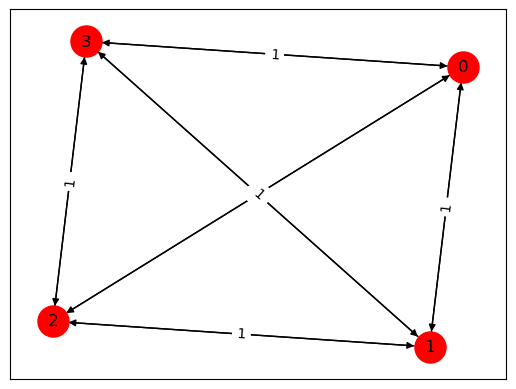

gb.VectorExpression               size  dtype
v_9.apply(unary.<lambda>[INT64])     4  INT64

"Result"   nvals  size  dtype
gb.Vector      4     4  INT64
-----------------------------
index  0  1  2  3
value  3  3  3  3

Do expr.new() or other << expr to calculate the expression.

In [9]:
#верну 4 вершины, но теперь каждая из вершин будет участвовать в 3х треугольниках (всего треугольников будет 4)
M3=gb.Matrix.from_coo(
    [0,2,0,1,2,2,3,3,1,0,3,1],
    [2,0,3,2,1,3,0,2,0,1,1,3],
    [1,1,1,1,1,1,1,1,1,1,1,1],
    nrows=4,
    ncols=4
)
gb.viz.draw(M3)
#проверяю, что все функции возвращают корректный результат
assert naive_A3(M3) == 4
assert naive_mask_A2(M3) == 4
assert cohen(M3) == 4
assert sandia(M3) == 4
count_triangles_per_vertex(M3)

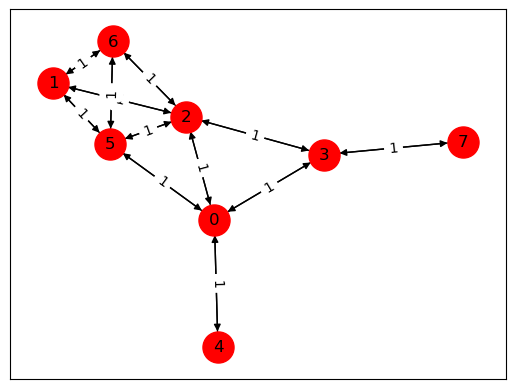

gb.VectorExpression                size  dtype
v_13.apply(unary.<lambda>[INT64])     8  INT64

"Result"   nvals  size  dtype
gb.Vector      6     8  INT64
-----------------------------
index  0  1  2  3 4  5  6 7
value  2  3  5  1    4  3  

Do expr.new() or other << expr to calculate the expression.

In [10]:
#увеличу количество вершин до 8, и пусть каждая участвует в нескольких треугольниках
#вершина 0 - в двух, вершины 1 и 6 - в трех, вершина 2 - в пяти
#вершина 3 - в одном, вершины 4 и 7 - ни в одном, вершина 5 - в четырех
#всего треугольников при этом будет 6
M4=gb.Matrix.from_coo(
    [0,2,0,1,2,2,3,3,4,5,6,7,3,2,1,0,6,5,0,5,6,1,5,2],
    [2,0,3,2,1,3,0,2,0,1,2,3,7,6,5,4,5,6,5,0,1,6,2,5],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    nrows=8,
    ncols=8
)
gb.viz.draw(M4)
#проверяю, что все функции возвращают корректный результат
assert naive_A3(M4) == 6
assert naive_mask_A2(M4) == 6
assert cohen(M4) == 6
assert sandia(M4) == 6
count_triangles_per_vertex(M4)

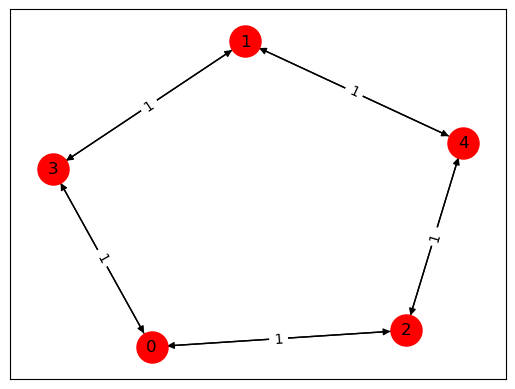

gb.VectorExpression                size  dtype
v_17.apply(unary.<lambda>[INT64])     5  INT64

"Result"   nvals  size  dtype
gb.Vector      0     5  INT64
-----------------------------
index 0 1 2 3 4
value          

Do expr.new() or other << expr to calculate the expression.

In [11]:
#задам граф вообще без треугольников с 5 вершинами
M5=gb.Matrix.from_coo(
    [3,1,0,2,0,3,4,1,4,2],
    [1,3,2,0,3,0,1,4,2,4],
    [1,1,1,1,1,1,1,1,1,1],
    nrows=5,
    ncols=5
)
gb.viz.draw(M5)
#проверяю, что все функции возвращают корректный результат
assert naive_A3(M5) == 0
assert naive_mask_A2(M5) == 0
assert cohen(M5) == 0
assert sandia(M5) == 0
count_triangles_per_vertex(M5)

**Тестирование на "реальных" графах**

In [12]:
#функция тестирования
#получаю время выполнения через timeit
def test(A):
    result = [naive_A3(A), naive_mask_A2(A), cohen(A), sandia(A)]
    print(result)
    if not all(result[0] == element for element in result):
        print("All return values are not equal")
    else:
        print('naive_A3:')
        %timeit naive_A3(A)
        print('naive_mask_A2:')
        %timeit naive_mask_A2(A)
        print('cohen:')
        %timeit cohen(A)
        print('sandia:')
        %timeit sandia(A)
        print('\n\n')

In [13]:
realGraph1=mmread('auto.mtx')
realGraph2=mmread('fe_4elt2.mtx')
realGraph3=mmread('fe_tooth.mtx')
realGraph4=mmread('mycielskian11.mtx')
realGraph5=mmread('G36.mtx')
realGraph6=mmread('EX4.mtx')
realGraph7=mmread('fe_body.mtx')
realGraph8=mmread('delaunay_n12.mtx')
realGraph9=mmread('fxm3_6.mtx')
realGraph10=mmread('G63.mtx')

In [14]:
graphAr=[realGraph1, realGraph2, realGraph3, realGraph4, realGraph5, realGraph6, realGraph7, realGraph8, realGraph9, realGraph10]
for i in graphAr:
  print(f'Количество вершин: {i.shape[0]}, количество ребер: {len(i.to_coo()[0])}')
  test(i)

Количество вершин: 448695, количество ребер: 6629222
[6245184, 6245184, 6245184, 6245184]
naive_A3:
The slowest run took 4.54 times longer than the fastest. This could mean that an intermediate result is being cached.
7.52 s ± 4.06 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
naive_mask_A2:
756 ms ± 62.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
cohen:
1.28 s ± 240 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
sandia:
1.03 s ± 292 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



Количество вершин: 11143, количество ребер: 65636
[21681, 21681, 21681, 21681]
naive_A3:
The slowest run took 9.58 times longer than the fastest. This could mean that an intermediate result is being cached.
38.5 ms ± 49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
naive_mask_A2:
3.81 ms ± 318 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
cohen:
3.36 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
sandia:
2.72 ms ± 80.6 µs per loop (mean

### Вывод:

По результатам теста можно заключить следующее:

- Наивный алгоритм демонстрирует значительно худшие временные показатели, чем другие алгоритмы;
- Наивный алгоритм с маской работает намного быстрее обычного наивного алгоритма (в десятки раз) за счет того, что не требуется второй раз умножать большие матрицы.
- Что насчет алгоритмов Cohens и Sandia, они работают на порядок быстрее, при этом более эффективным оказался алгоритм Sandia.

**Тестирование случайных графов**

Функция получает количество вершин и ребер;
Случайно отбираются пары вершин из элементов выше диагонали матрицы смежности в количестве заданных ребер;
Индексы выбранных вершин вместе с симметричными им (по причине того, что граф неориентированный) добавляются в списки;
"Собирается" матрица из формата соо по спискам индексов и значений (для всех ребер вес выставлялся равным 1).

In [15]:
def generate_graph(num_vertices, num_edges):
    import random
    #создание множества, состоящего из номеров ячеек верхнетреугольной матрицы (без диагональных элементов)
    high_positions=[]
    for ind in range(num_vertices**2):
        if ind // num_vertices < ind % num_vertices:
            high_positions.append(ind)

    #Отбор num_edges случайных индексов вершин (случайные значения из high_positions) для создания ребер
    gen_indices = random.sample(high_positions, num_edges)
    
    #Преобразование индексов в координаты (строка, столбец)
    row_indices, col_indices = np.unravel_index(gen_indices, (num_vertices, num_vertices))
    #Добавление симметричных координат относительно диагонали матрицы
    indices_from = np.append(col_indices, row_indices)
    indices_to = np.append(row_indices, col_indices)
    
    return gb.Matrix.from_coo(indices_from, indices_to, [1]*len(indices_from), nrows=num_vertices, ncols=num_vertices)

In [16]:
#как ведет себя время для очень разреженых графов с увеличением числа вершин
for i in range(1000, 10000, 1000):
    print(f'Количество вершин: {i}, количество ребер: 10')
    generated_graph = generate_graph(i, 10)
    test(generated_graph)

Количество вершин: 1000, количество ребер: 10
[0, 0, 0, 0]
naive_A3:
198 µs ± 25.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
naive_mask_A2:
140 µs ± 10.2 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
cohen:
223 µs ± 6.33 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
sandia:
177 µs ± 10.6 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)



Количество вершин: 2000, количество ребер: 10
[0, 0, 0, 0]
naive_A3:
149 µs ± 3.2 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
naive_mask_A2:
117 µs ± 2.15 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
cohen:
219 µs ± 2.11 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
sandia:
175 µs ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)



Количество вершин: 3000, количество ребер: 10
[0, 0, 0, 0]
naive_A3:
162 µs ± 19.4 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
naive_mask_A2:
122 µs ± 8.51 µs per loop (mean ± std. dev. of 7 r

1. Наивный алгоритм почти всегда быстрее своих оптимизированных "коллег" (так как алгоритмы Cohen и Sandia рассчитаны, в первую очередь, на более плотные графы с большим количеством вершин).
2. Наиболее эффективным по времени оказался наивный алгоритм с маской, оптимизирующий наивный алгоритм путем замены дорогой по времени операции умножения матриц на поэлементное умножение (или "просеивание" через маску).
3. Однако, результаты теста нельзя назвать значимыми для практического применения, поскольку очень редко на практике приходится работать с относительно малыми и настолько разреженными графами.

In [17]:
#как ведет себя время для очень разреженых графов с увеличением числа вершин
for i in range(10000, 100000, 10000):
    print(f'Количество вершин: 1000, количество ребер: {i}')
    generated_graph = generate_graph(1000, i)
    test(generated_graph)

Количество вершин: 1000, количество ребер: 10000
[1375, 1375, 1375, 1375]
naive_A3:
31.3 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
naive_mask_A2:
1.72 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
cohen:
1.28 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
sandia:
671 µs ± 60.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)



Количество вершин: 1000, количество ребер: 20000
[10552, 10552, 10552, 10552]
naive_A3:
29.2 ms ± 547 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
naive_mask_A2:
3.73 ms ± 53.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
cohen:
2.62 ms ± 56.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
sandia:
2.01 ms ± 433 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)



Количество вершин: 1000, количество ребер: 30000
[35964, 35964, 35964, 35964]
naive_A3:
48.7 ms ± 8.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
naive_mask_A2:
6.41 ms ± 12

1. С увеличением плотности графа с большим числом вершин наивный алгоритм стал значительно проигрывать более оптимальным подходам.
2. Наивный алгоритм с маской по-прежнему немного более эффективен за счет отказа от дорогостоящего перемножения матриц (однако, на некоторых примерах работает даже дольше обычного наивного).
3. Наиболее эффективным алгоритмом по результатам теста оказался Sandia, поскольку использует только верхний треугольник исходной матрицы смежности графа. Также алгоритм наиболее эффективен и по занимаемой памяти, т.к. хранит только верхнетреугольную матрицу (в отличие от Cohen, в котором хранятся 2: верхнетреугольная и нижнетреугольная).
4. Можно сказать о том, что результаты этого теста практически применимы. Алгоритмы Sandia и Cohen's предпочтительно использовать при решении практических задач.


**Основные выводы**

 1. Анализ графовых данных имеет практическое применение в следующих задачах:
- кластеризация клиентов и предсказание связей (например, при рекомендациях друзей в соц. сетях по общим группам или контактам);
- анализ сходства (например, для подбора аудитории для рекламы чего-либо, формирования фокус-групп);
- всевозможные банковские скоринги (через связи между руководителями разных фирм, совместными проектами и влиянием друг на друга);
- выявление мошенничества (через анализ связей клиентов с потенциальными мошенниками и сравнение данных с реальными мошшеническими действиями);
- построение и оптимизация маршрутов (актуально в приложениях и платформах карт).
 2. Наивный алгоритм можно использовать при очень плотных или очень разреженных матрицах, в остальных случаях (в т.ч. при реальных задачах, что показал тест на графах с сайта) более оптимальным (по времени и памяти) является, в первую очередь, алгоритм Sandia. Также неплохие результаты показывает Cohen's алгоритм.
